# Cab-Driver Agent

In [0]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import os

# For building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# For plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

## Defining Time Matrix

In [0]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

## Track for checking convergence

<B> Convergence is being tracked through stability of the total rewards per episode as also the average rewards per trip per episode. Plots are shown towards the end of the notebook.

In [0]:
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Agent Class

If using this framework, fill following to complete code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete function 'append_sample()' to append recent experience tuple <state, action, reward, new-state> to memory
6. Complete the 'train_model()' function with following logic:
   - If memory size is greater than mini-batch size, randomly sample experiences from memory as per mini-batch size and do following:
      - Initialise input and output batch for training the model
      - Calculate target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from last trained model
      - Update input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using updated input and output batch.

In [0]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):
        # Size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Hyper parameters for DQN
        self.load_model = False
        
        self.discount_factor = 0.95
        self.learning_rate =  0.01
        
        # epsilon values
        self.epsilon_max = 1.0000
        self.epsilon_min = 0.0001
        #self.epsilon_decay = 0.00025
        self.epsilon_decay = 0.9998
        self.epsilon = 1.0000 
                
        self.batch_size = 32     

        self.memory = deque(maxlen=2000) # Create replay memory using deque

        # Create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        

    # Aproximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # Output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
    
    
    # Save keras model
    def save(self, name):
        self.model.save_weights(name)    
        
    
    # save sample <s,a,r,s'> to replay memory
    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
            
                
    # pick samples randomly from replay memory (with batch_size) and train network
    def train_model(self):
        if len(self.memory) <= self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)

        update_input = np.zeros((self.batch_size, self.state_size))
        update_output = np.zeros((self.batch_size, self.state_size))

        actions, rewards = [], []

        # Update 'update_output' and 'update_input' batch. 
        for i in range(self.batch_size):
            state, action, reward, next_state = mini_batch[i]
            state_encod = env.state_encod_arch2(state, action)
            next_state_encod = env.state_encod_arch2(next_state, action)

            update_input[i] = state_encod
            actions.append(action)
            rewards.append(reward)
            update_output[i] = next_state_encod

        # Predict target from earlier model
        target_ip_qval = self.model.predict(update_input)  
        target_op_qval = self.model.predict(update_output)

        # Get target for Q-network
        for i in range(self.batch_size):
            target_ip_qval[i][actions[i]] = \
                rewards[i] + self.discount_factor * np.max(target_op_qval[i])

        # Fit model and track loss values
        self.model.fit(update_input, target_ip_qval, batch_size=self.batch_size, epochs=1, verbose=0)
        
        
    def get_action(self, state):
        # Get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from environment
        
        possible_actions_idx, actions = env.requests(state) 
        
        if np.random.rand() <= self.epsilon_max:
            # explore: a random action from all possible actions
            return random.sample(actions, 1)[0]
        else:
            # exploit: action with highest q(s, a)
            state_action = np.zeros((len(actions), self.state_size))
            for action in actions:
                state_action = env.state_encod_arch2(state, action)                
            q_values = self.model.predict(state_action)
            return actions[np.argmax(q_values)]

In [0]:
EPISODES = 20000
TRACKING_INTERVAL = 1000
RUN_STATE_INTERVAL = 25

## DQN block

In [8]:
import time

# Call the environment and all initialised variables of the environment
# get size of state and action from environment
env = CabDriver()
state_size = len(env.state_encod_arch2(env.state_init, [0,0]))
action_size = len(env.action_space)

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# Total rewards in episode
tot_rwds_in_epi = []
t_tot_rwds_in_epi = []
# Average rewards in episode
av_rwds_in_epi = []
t_av_rwds_in_epi = []
# Maximum rewards day in episode
max_rwds_day_in_epi = []
t_max_rwds_day_in_epi = []
# Average of daily rewards in episode
av_daily_rwds_in_epi = []
t_av_daily_rwds_in_epi = []
# Track time taken
start_time = time.time()
total_time = 0

for episode in range(1, EPISODES+1):    
    env_init_values = env.reset() 
    initial_state = env_init_values[2]
    
    terminal_state = False
    rewards_per_day = []
    reward_per_day = 0
    total_reward = 0
    total_trip = 0
    total_hours = 0
    
    curr_state = initial_state
        
    while terminal_state == False:
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append experience to memory
        # 4. Train model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        # get action for the current state and take a step in the environment
        action = agent.get_action(curr_state)
        new_state = env.next_state_func(curr_state, action, Time_matrix)
        trip_reward, trip_time = env.reward_func(curr_state, action, Time_matrix)
        total_hours += trip_time
        reward_per_day += trip_reward
        
        # Check termination condition
        terminal_state = (total_hours >= 720)
            
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(curr_state, action, trip_reward, new_state)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        if new_state[2] != curr_state[2]:
            rewards_per_day.append(reward_per_day)
            reward_per_day = 0
            
        total_reward += trip_reward
        total_trip += 1
        curr_state = new_state
        

    tot_rwds_in_epi.append([episode, total_reward])
    av_rwds_in_epi.append([episode, round(total_reward/total_trip, 2)])
    max_rwds_day_in_epi.append([episode, round(np.max(rewards_per_day),2)])
    av_daily_rwds_in_epi.append([episode, round(np.mean(reward_per_day),2)])

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
        #agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*i)
        
    # every few episode:
    if episode % RUN_STATE_INTERVAL == 0:
        print()
        time_taken = time.time() - start_time
        total_time += time_taken
        
        print('Total Reward in episodes', t_tot_rwds_in_epi)
        print('Average Reward in episodes', t_av_rwds_in_epi)
        print('Maximum Reward day in episode', t_max_rwds_day_in_epi)
        print('Average Daily Reward in episode', t_av_daily_rwds_in_epi)
        print("Episode {0}, Reward {1}, memory_length {2}, Epsilon {3}, Time taken {4}, Total Time {5}".format(
            episode, total_reward, len(agent.memory), round(agent.epsilon,4),  
            round(time_taken,2), round(total_time,2)))
        
        t_tot_rwds_in_epi.clear()
        t_av_rwds_in_epi.clear()
        t_max_rwds_day_in_epi.clear()
        t_av_daily_rwds_in_epi.clear()
        
        start_time = time.time()
    else:
        t_tot_rwds_in_epi.append(total_reward)
        t_av_rwds_in_epi.append(round(total_reward/total_trip, 2))
        t_max_rwds_day_in_epi.append(round(np.max(rewards_per_day),2))
        t_av_daily_rwds_in_epi.append(round(np.mean(rewards_per_day),2))
    
    # Track rewards
    if episode % TRACKING_INTERVAL == 0:
        print() 
        print("Episode {0}, Saving Model, Total Time {1}".format(episode, round(total_time,2)))
        agent.save(name="model_weights.h5")
        
save_pickle(tot_rwds_in_epi, "total_rewards_per_episode")
print()        
print("Total run time", total_time)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Total Reward in episodes [-85.0, -194.0, -365.0, -50.0, -52.0, 116.0, -208.0, -144.0, -313.0, -149.0, -281.0, -72.0, -36.0, 154.0, -273.0, 144.0, -356.0, 143.0, -221.0, -90.0, -108.0, -253.0, -330.0, -259.0]
Average Reward in episodes [-0.6, -1.31, -2.48, -0.33, -0.36, 0.84, -1.51, -1.0, -2.34, -1.01, -2.07, -0.5, -0.25, 0.96, -2.18, 1.12, -2.85, 1.02, -1.51, -0.58, -0.79, -1.7, -2.43, -1.92]
Maximum Reward day in episode [85.0, 48.0, 56.0, 68.0, 66.0, 53.0, 96.0, 47.0, 95.0, 98.0, 57.0, 43.0, 88.0, 70.0, 46.0, 51.0, 44.0, 91.0, 43.0, 76.0, 42.0, 71.0, 36.0, 40.0]
Average Daily Reward in episode [-2.31, -6.69, -11.61, -1.86, -1.79, 4.0, -7.17, -4.97, -10.07, -5.46, -9.69, -3.0, -2.14, 6.29, -10.07, 5.69, -12.28, 5.34, -7.36, -2.36, -2.61, -9.18, -11.38, -7.86]
Episode 25, Reward -138.0, memory_length 2000, Epsilon 0.995, Time taken 14.46, Total Time 14.46

Total Rewa

## Tracking Convergence

In [9]:
import pandas as pd

tot_rwds_in_epi_df = pd.DataFrame(tot_rwds_in_epi, columns=['episode', 'total reward'])
av_rwds_in_epi_df = pd.DataFrame(av_rwds_in_epi, columns=['episode', 'average reward'])
max_rwds_day_in_epi_df = pd.DataFrame(max_rwds_day_in_epi, columns=['episode', 'max reward day'])
av_daily_rwds_in_epi_df = pd.DataFrame(av_daily_rwds_in_epi, columns=['episode', 'average daily reward'])
    
tot_rwds_in_epi_df = tot_rwds_in_epi_df.set_index('episode')
tot_rwds_in_epi_df.describe()

,total reward
count,20000.000000
mean,-165.679850
std,165.831706
min,-815.000000
25%,-279.000000
50%,-167.000000
75%,-52.000000
max,431.000000


### Total rewards frequency

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d888a5128>],
      dtype=object)

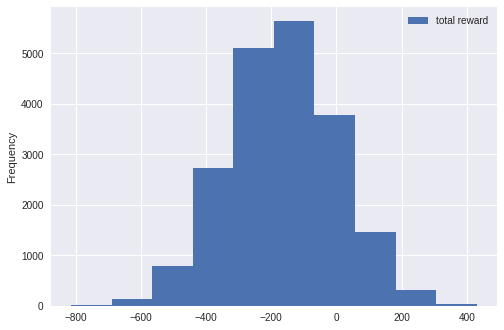

In [10]:
tot_rwds_in_epi_df.plot(kind='hist', subplots=True, use_index=True)

### Total rewards convergence distribution over episodes 

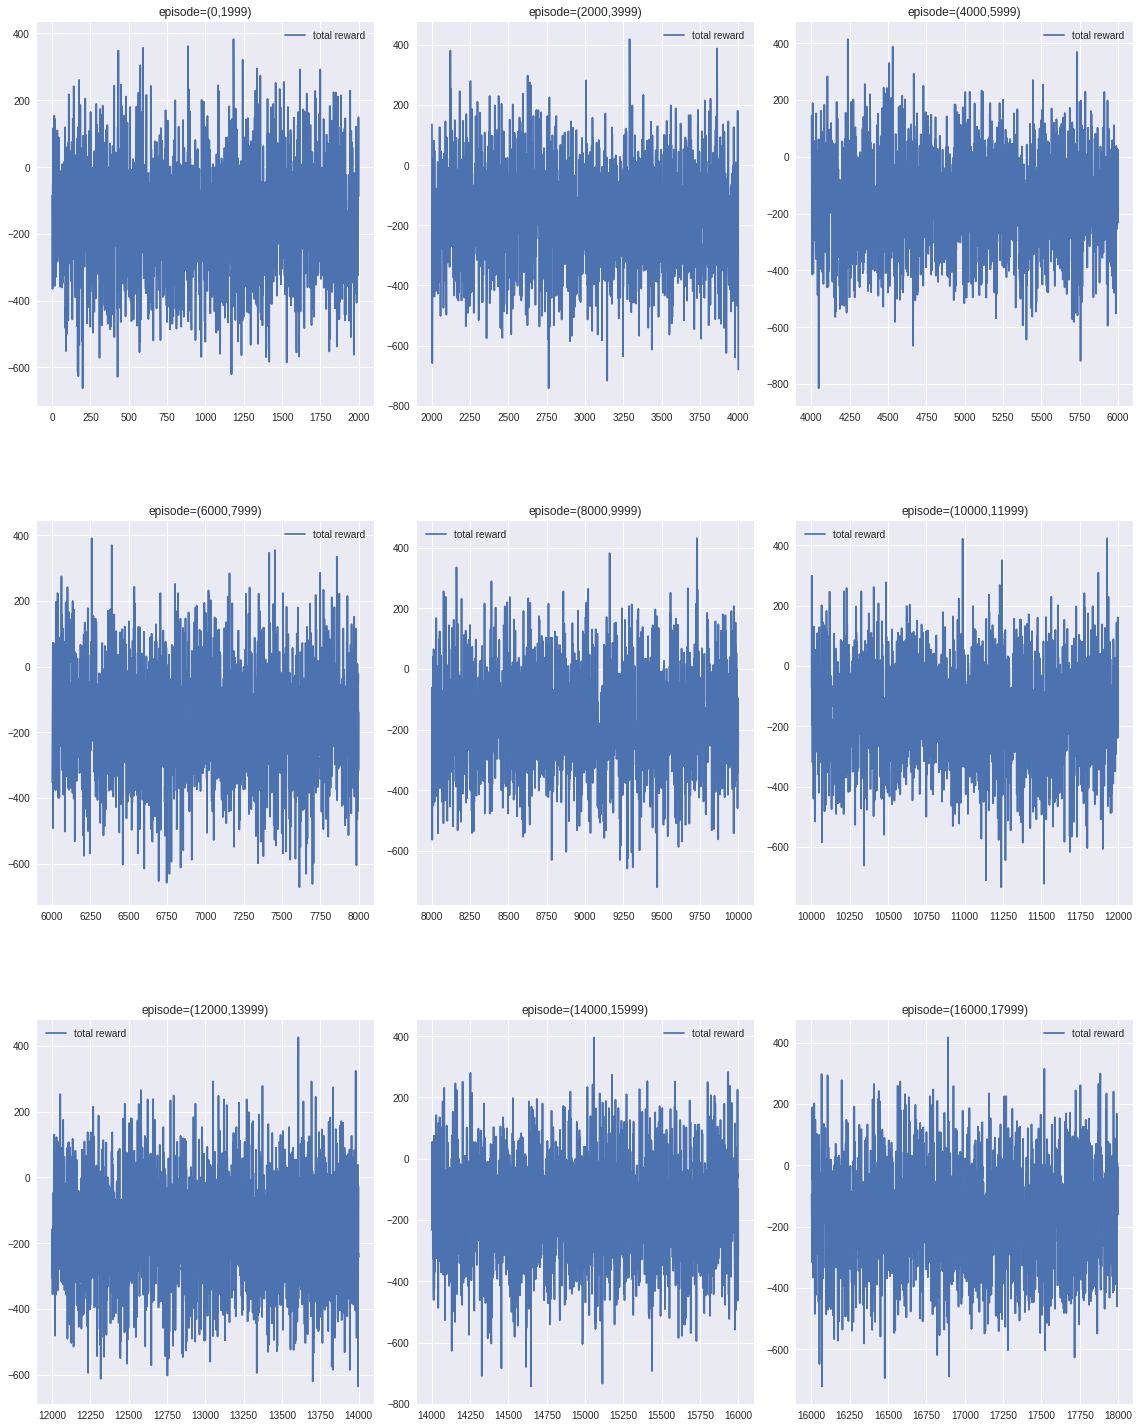

In [11]:
import seaborn as sns
rows_to_choose = int(tot_rwds_in_epi_df.shape[0]/10)

plt.figure(0, figsize=(16,20))

for x in range(1,10):
    plt.subplot(int('33{0}'.format(x)))
    start = (x-1)*rows_to_choose
    end = (x * rows_to_choose) - 1
    plt.title('episode=({0},{1})'.format(start, end))
    plt.plot(tot_rwds_in_epi_df[start:end]['total reward'], label="total reward")
    plt.legend()
    plt.tight_layout()
    
    plt.subplots_adjust(hspace = .3)

plt.show()

### Average rewards convergence distribution over episodes 

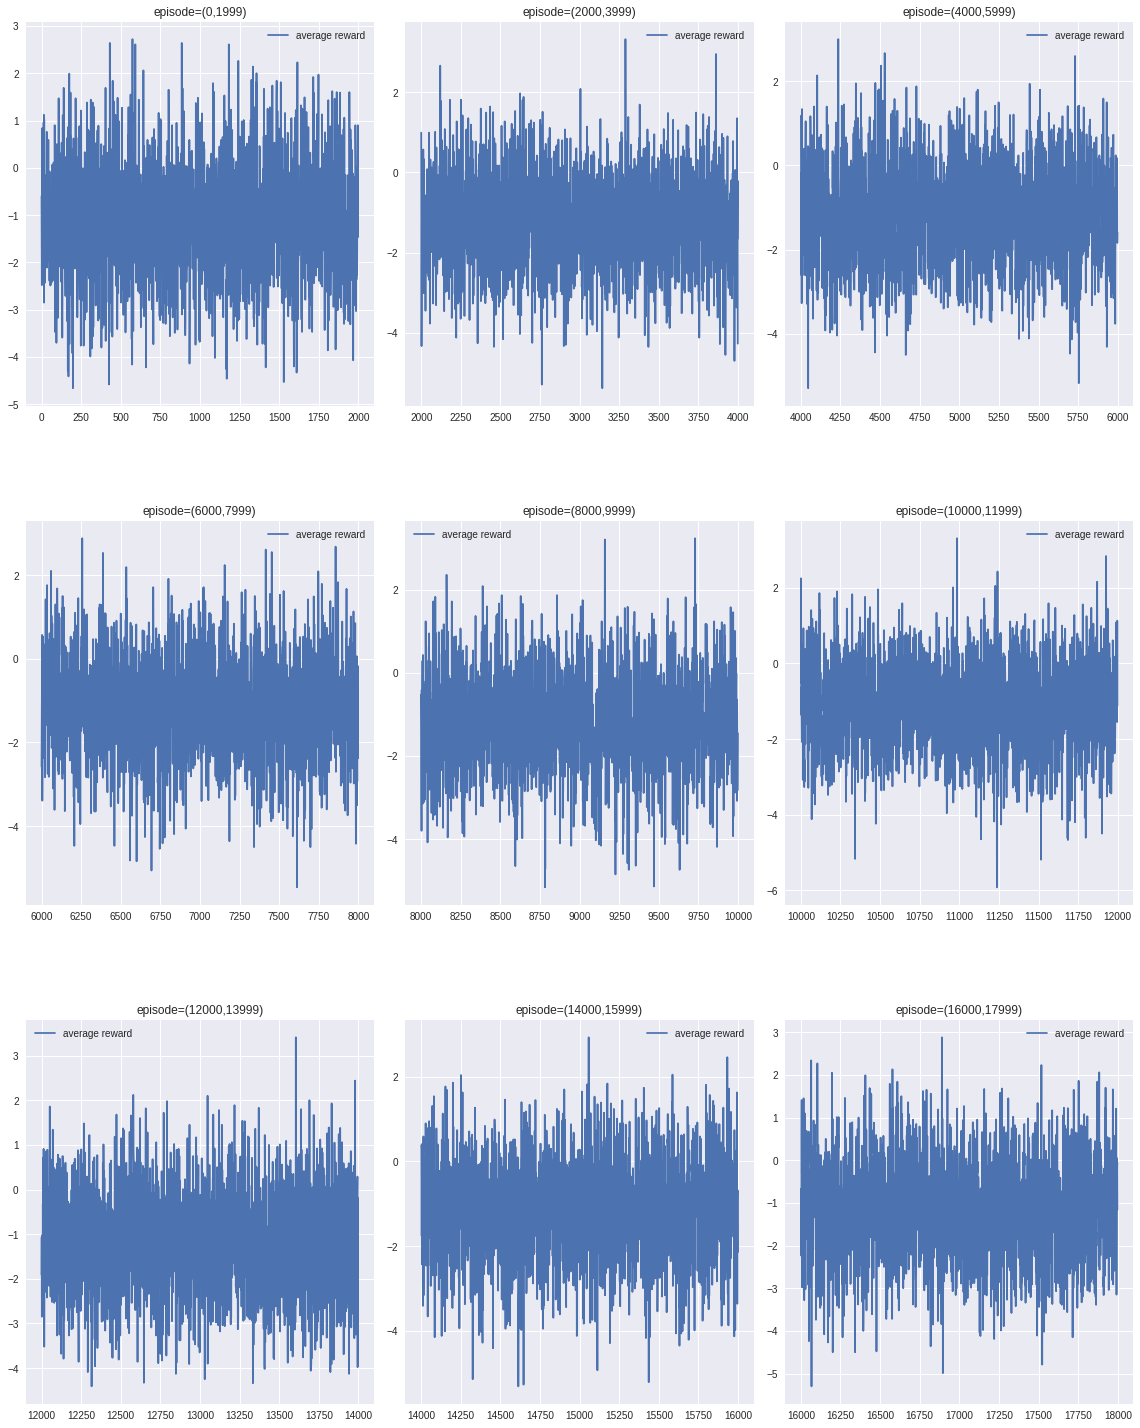

In [12]:
rows_to_choose = int(av_rwds_in_epi_df.shape[0]/10)

plt.figure(0, figsize=(16,20))

for x in range(1,10):
    plt.subplot(int('33{0}'.format(x)))
    start = (x-1)*rows_to_choose
    end = (x * rows_to_choose) - 1
    plt.title('episode=({0},{1})'.format(start, end))
    plt.plot(av_rwds_in_epi_df[start:end]['average reward'], label="average reward")
    plt.legend()
    plt.tight_layout()
    
    plt.subplots_adjust(hspace = .3)

plt.show()

### Maximum value of reward for any day in an epidoe (convergence distribution over episodes) 

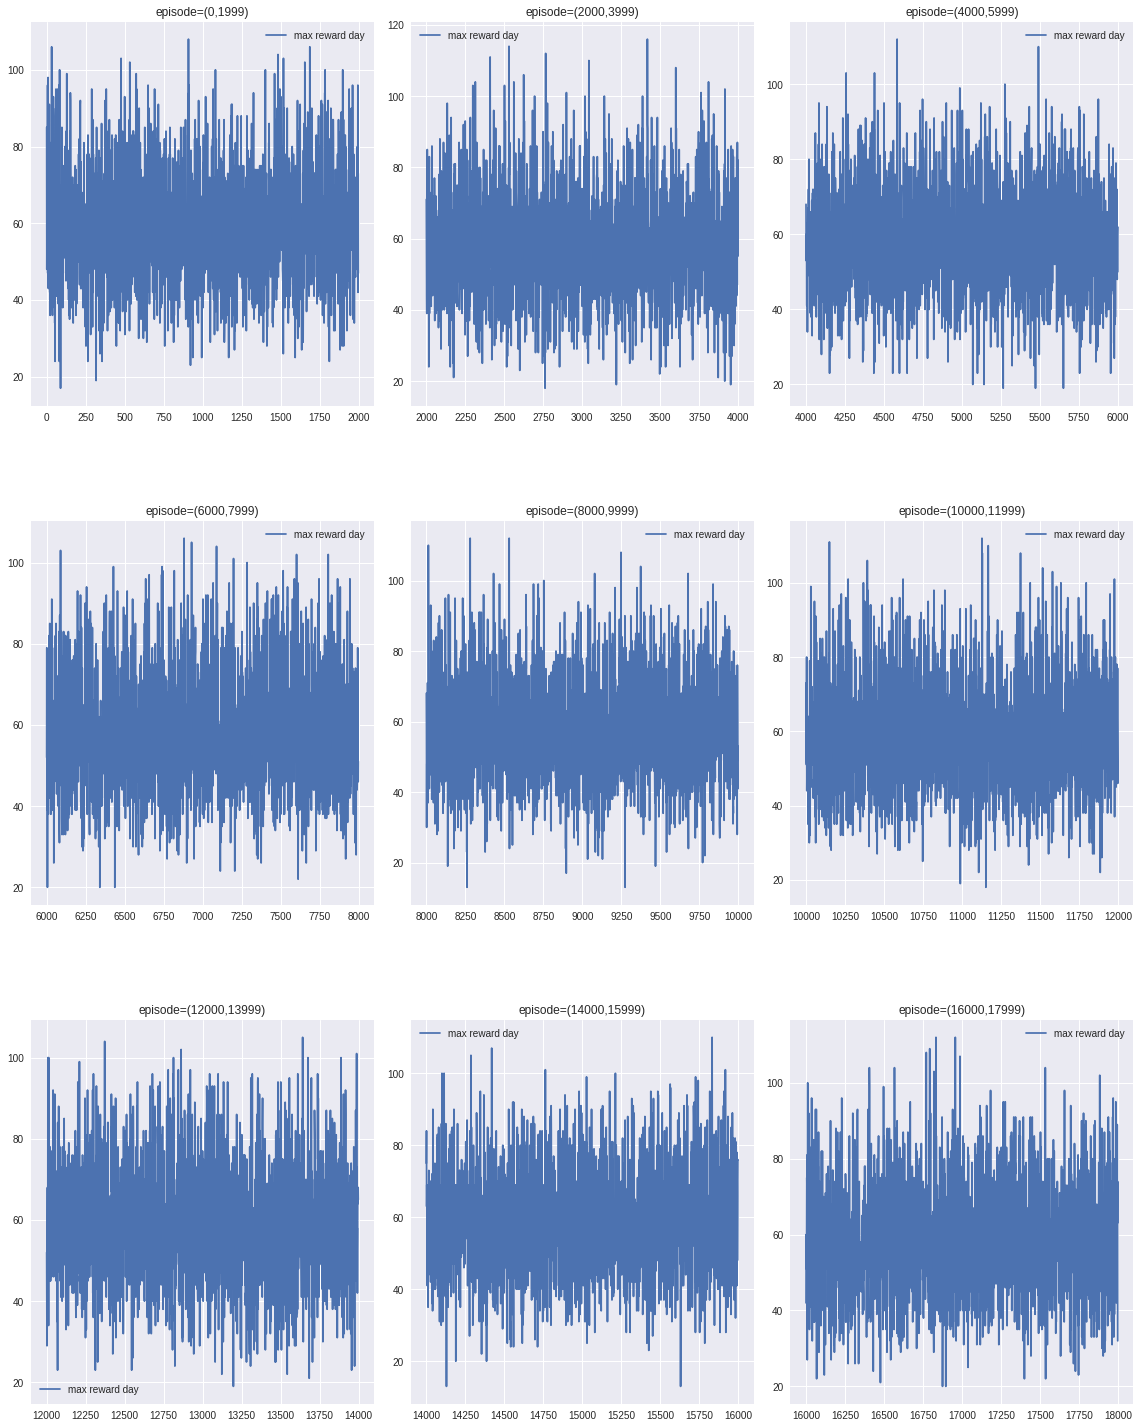

In [13]:
rows_to_choose = int(max_rwds_day_in_epi_df.shape[0]/10)
plt.figure(0, figsize=(16,20))

for x in range(1,10):
    plt.subplot(int('33{0}'.format(x)))
    start = (x-1)*rows_to_choose
    end = (x * rows_to_choose) - 1
    plt.title('episode=({0},{1})'.format(start, end))
    plt.plot(max_rwds_day_in_epi_df[start:end]['max reward day'], label="max reward day")
    plt.legend()
    plt.tight_layout()
    
    plt.subplots_adjust(hspace = .3)

plt.show()

### Average of daily rewards - convergence distribution over episodes 

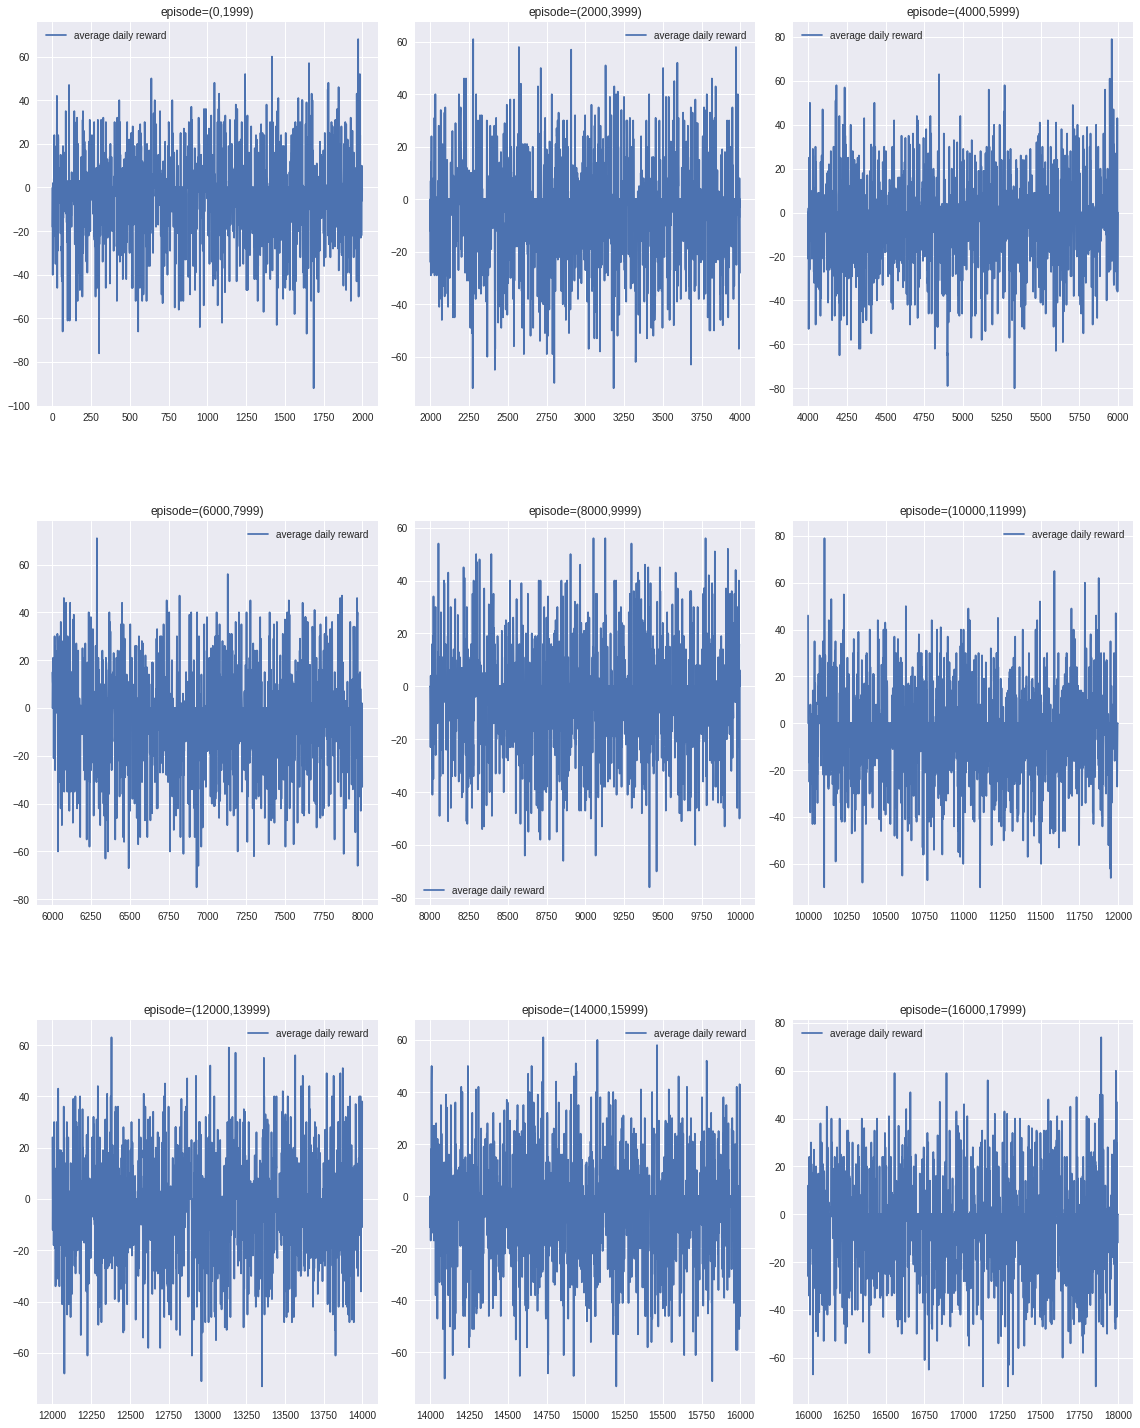

In [14]:
rows_to_choose = int(av_daily_rwds_in_epi_df.shape[0]/10)
plt.figure(0, figsize=(16,20))

for x in range(1,10):
    plt.subplot(int('33{0}'.format(x)))
    start = (x-1)*rows_to_choose
    end = (x * rows_to_choose) - 1
    plt.title('episode=({0},{1})'.format(start, end))
    plt.plot(av_daily_rwds_in_epi_df[start:end]['average daily reward'], label="average daily reward")
    plt.legend()
    plt.tight_layout()
    
    plt.subplots_adjust(hspace = .3)

plt.show()

In [0]:
save_pickle(av_daily_rwds_in_epi, "av_daily_rwds_in_epi")
save_pickle(av_rwds_in_epi, "av_rwds_in_epi")
save_pickle(max_rwds_day_in_epi, "max_rwds_day_in_epi")

## Epsilon-decay function

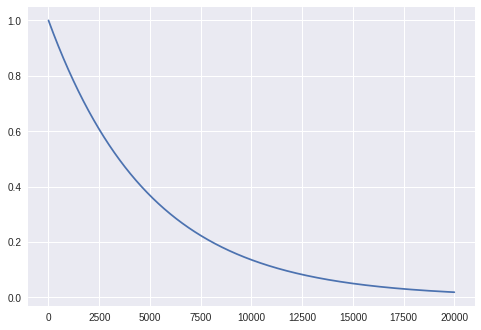

In [15]:
max = 20000

epsilon_v = 1.0
min_epsilon = 0.0001
max_epsilon = 1.0000
epsilon_decay = 0.9998
#epsilon_decay = 0.00025
time = np.arange(0,max)
epsilons = []
for i in range(0,max):
    if epsilon_v > min_epsilon:
        epsilon_v *= epsilon_decay
        #epsilon_v = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay*i)
    epsilons.append(epsilon_v)
    
plt.plot(time, epsilons)
plt.show()